<a href="https://colab.research.google.com/github/GUNWOOOH/ADP_Practice/blob/main/%EC%8B%A4%EC%8A%B5/ADP_%EB%B3%80%EC%88%98%EC%84%A0%ED%83%9D_VIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#17회 ADP 실기

# 4-3. 2차 교호작용항까지 고려한 회귀분석을 수행하고, 변수 선택 과정을 제시하시오.

=> VIF를 활용하여 문제풀이

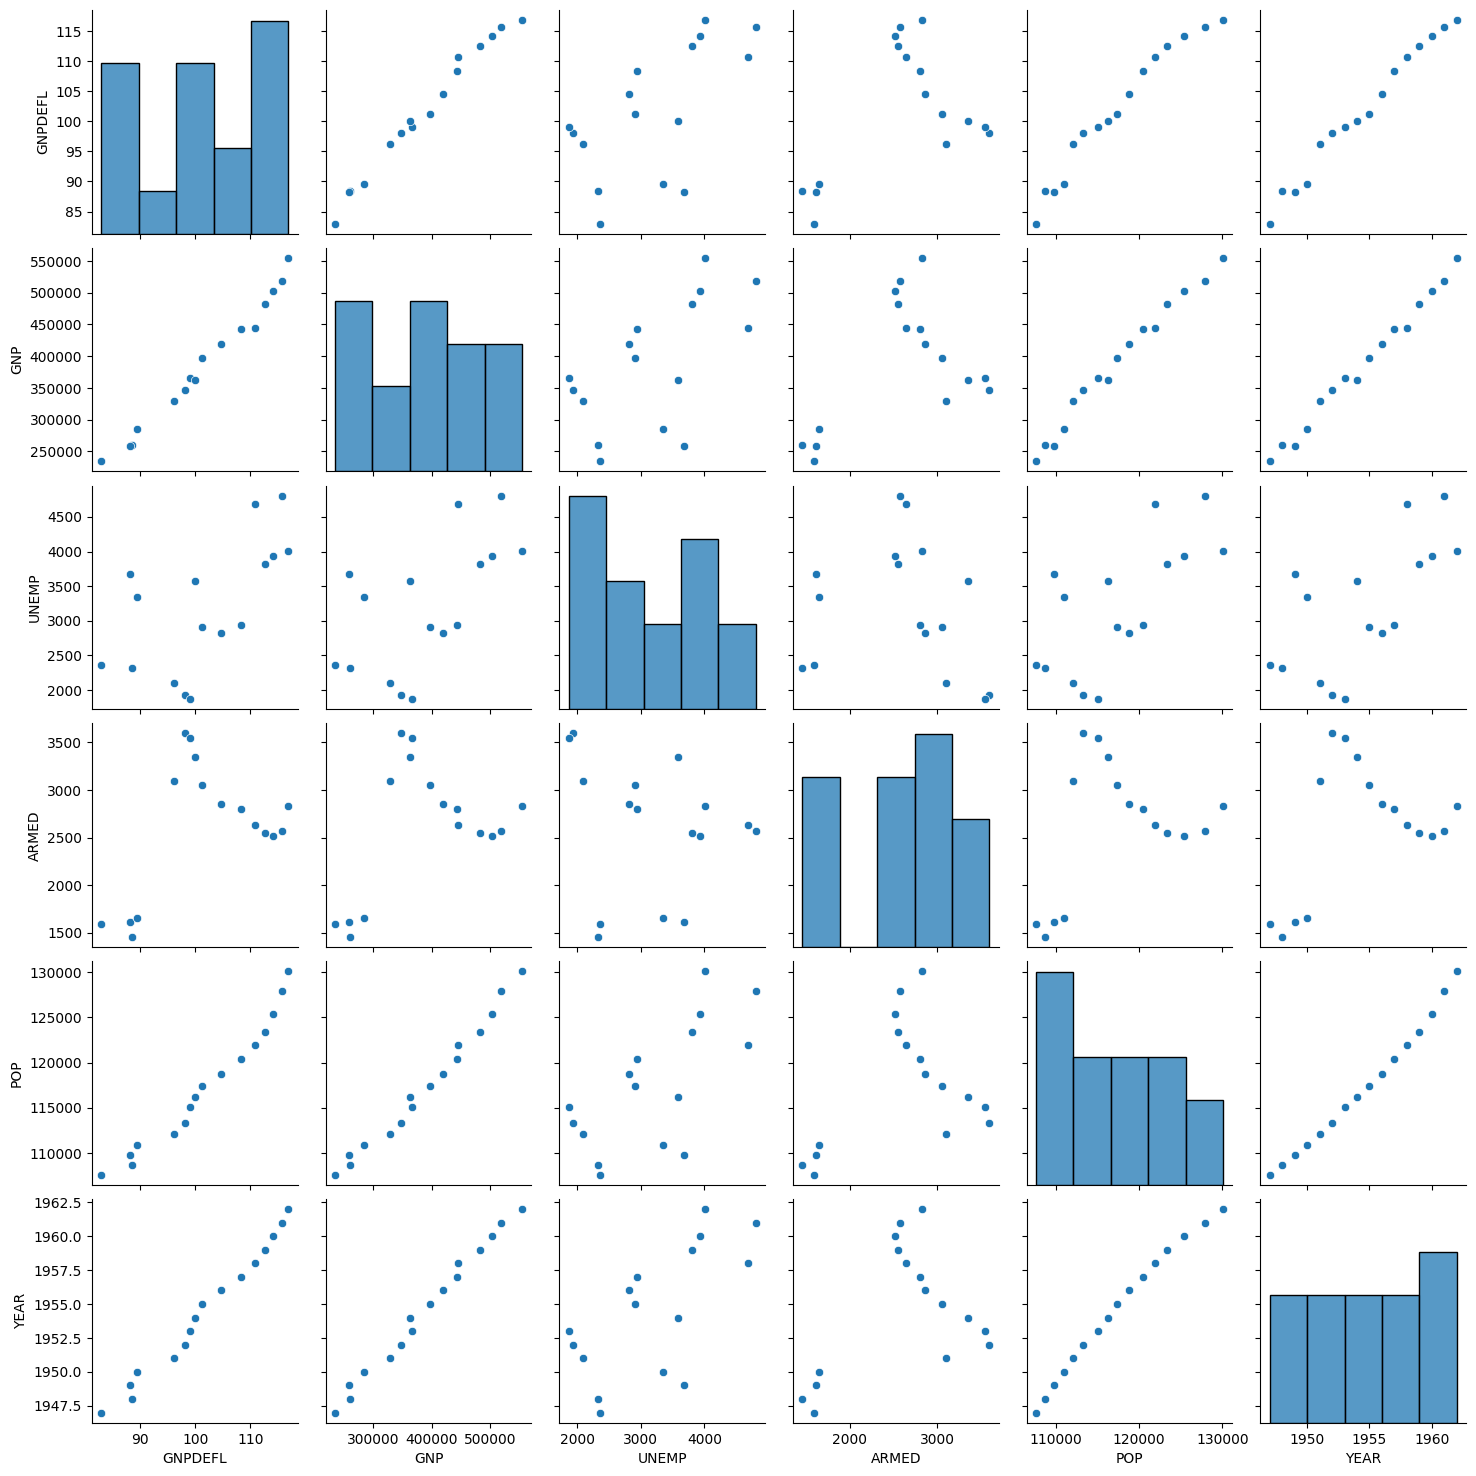

In [7]:
from statsmodels.datasets.longley import load_pandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

In [8]:
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


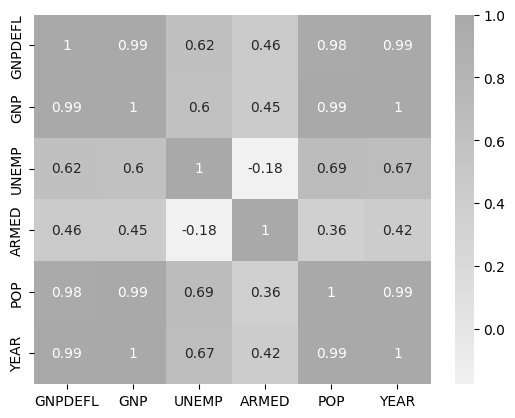

In [9]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, cmap=cmap)
plt.show()

In [11]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNPDEFL + POP + GNP + YEAR + ARMED + UNEMP", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary())
#과적합이 일어난 모습을 볼 수 있다.

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Thu, 05 Oct 2023   Prob (F-statistic):             0.0366
Time:                        05:15:04   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [14]:
def calc_r2(df_test, result):
    target = df.loc[df_test.index].TOTEMP
    predict_test = result.predict(df_test)
    RSS = ((predict_test - target)**2).sum()
    TSS = ((target - target.mean())**2).sum()
    return 1 - RSS / TSS


test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    test1.append(calc_r2(df_test, result))

test1 #결과를 보면 80%대도 있는걸 보니 train 보다 test에서 성능이 낮은 모습

[0.9815050656835879,
 0.9738497543068891,
 0.9879366369959809,
 0.7588861967884393,
 0.9807206089304463,
 0.8937889315167613,
 0.8798563810612743,
 0.9314665778966528,
 0.860852568217504,
 0.9677198735169414]

1. 변수 선택법으로 의존적인 변수 삭제

2. PCA(principal component analysis) 방법으로 의존적인 성분 삭제

3. 정규화(regularized) 방법 사용

# VIF

다중 공선성을 없애는 가장 기본적인 방법은 다른 독립변수에 의존하는 변수를 없애는 것이다. 가장 의존적인 독립변수를 선택하는 방법으로는 VIF(Variance Inflation Factor)를 사용할 수 있다.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


In [16]:
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Thu, 05 Oct 2023   Prob (F-statistic):           0.000231
Time:                        05:27:25   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


상관계수와 VIF를 사용하여 독립 변수를 선택하면 GNP, ARMED, UNEMP 세가지 변수만으로도 비슷한 수준의 성능이 나온다는 것을 알 수 있다.


In [18]:
test2 = []
for i in range(10):
    df_train, df_test, result = get_model2(i)
    test2.append(calc_r2(df_test, result))

test2 #과최적합이 없어진 모습

[0.9763608388904903,
 0.9841984331185702,
 0.968706936614014,
 0.9397304053201774,
 0.9773357061188463,
 0.9561262155732314,
 0.980385249669864,
 0.9917361722470804,
 0.9837134067639471,
 0.9789512977093213]